# Bitcoin prediction - Daily

This is a group project that we are still working on and testing the impact of parameters. 


In [ ]:
import datetime
from datetime import datetime, timezone
import datetime as dt
import numpy as np

import pandas as pd
import requests



import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')



from sklearn.model_selection import train_test_split

import seaborn as sns

import tensorflow as tf
import keras


from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, LSTM, Dropout, GlobalMaxPooling1D, SimpleRNN
from keras.callbacks import ModelCheckpoint, EarlyStopping



import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error




## Date processing

In [2]:
#Date input from user
print("Please add 1 hour to the `to` input to make sure that you always get data for the end date as well.")

start_date = str(input('Enter a start date in YYYY-MM-DD-H-M (2021-12-27-14-41) format: '))
end_date = str(input('Enter a end date in YYYY-MM-DD-H-M (2021-12-27-14-41) format: '))

Please add 1 hour to the `to` input to make sure that you always get data for the end date as well.
Enter a start date in YYYY-MM-DD-H-M (2021-12-27-14-41) format: 2020-01-01-12-00
Enter a end date in YYYY-MM-DD-H-M (2021-12-27-14-41) format: 2022-01-18-12-00


# Data preprocessing


In [3]:
def get_bitcoin_data_df(start_date, end_date):

    print( "the bitcoin data between {} and {} dates is being obtained".format(start_date,end_date))

    #Converting the entered date data to datetime format
    start_date_timestamp = datetime.strptime(start_date, "%Y-%m-%d-%H-%M")
    end_date_timestamp = datetime.strptime(end_date, "%Y-%m-%d-%H-%M")

    #Converting the entered date information to timestamp
    timestamp1 = start_date_timestamp.replace(tzinfo=timezone.utc).timestamp()
    timestamp2 = end_date_timestamp.replace(tzinfo=timezone.utc).timestamp()
    
    #Getting the needed data from CoinGecko’s public API 
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=eur&from={}&to={}".format(timestamp1,timestamp2)
    req = requests.get(url=url)
    json=req.json()
    
    #Converting json data to dataframe
    df1 = pd.DataFrame(json['prices'],columns=["time","prices"])
    df2 = pd.DataFrame(json['market_caps'],columns=["time","market_caps"])
    df3 = pd.DataFrame(json['total_volumes'],columns=["time","total_volumes"])
    df=df1.merge(df2, how='left', on='time')
    df=df.merge(df3, how='left', on='time')
    
    #Converting timestamp information of time column to datetime format
    timestamp=df["time"].tolist()  
    time=[]
    for i in timestamp: 
        i=int(str(i)[:10])
        date = dt.datetime.utcfromtimestamp(i)
        time.append(date)
    df["time"]=time
    
    #Indexing the time column
    df.set_index('time', inplace=True)
    
    #Selecting data at 00:00 UTC from hourly data, when given a date range of 1 to 90 days
    df=df[(df.index.hour ==0 )]
    
    return df


In [4]:
# Data
df=get_bitcoin_data_df(start_date, end_date)
print('\n', df.head())

print('\n ---------------------\n')

print(df.tail())

the bitcoin data between 2020-01-01-12-00 and 2022-01-18-12-00 dates is being obtained

                  prices   market_caps  total_volumes
time                                                
2020-01-02  6412.448167  1.162156e+11   1.615514e+10
2020-01-03  6234.201691  1.130466e+11   1.818484e+10
2020-01-04  6541.826288  1.189716e+11   2.779318e+10
2020-01-05  6587.554275  1.196064e+11   1.847005e+10
2020-01-06  6585.067986  1.194593e+11   1.964707e+10

 ---------------------

                  prices   market_caps  total_volumes
time                                                 
2022-01-14  37184.998544  7.038541e+11   3.831720e+10
2022-01-15  37774.601606  7.149432e+11   1.772911e+10
2022-01-16  37867.280489  7.155310e+11   1.283453e+10
2022-01-17  37793.204220  7.154849e+11   1.266705e+10
2022-01-18  37075.172762  7.019731e+11   1.550989e+10


# Data visualization

In [5]:
def get_n_last_days(df, n_days):
    """
    Extract last n_days 
    """
    
    return df['prices'][- n_days:] 

def plot_n_last_days(df, n_days):
    """
    Plot last n_days
    """
    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df,  n_days), 'k-') # call the previous function
    plt.title('Bitcoin Prices, last - {} days'
              .format( n_days))
    plt.xlabel('Recorded daily')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

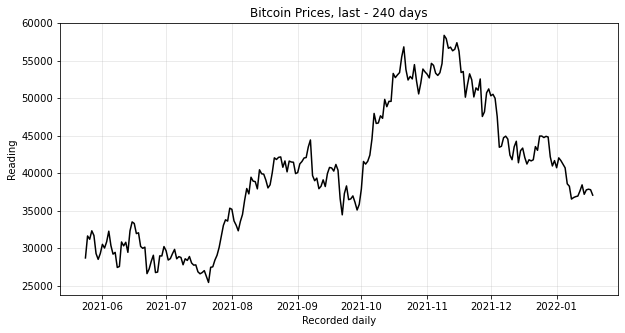

In [6]:
plot_n_last_days(df, 240)


### A. How many days is the longest bearish (downward) trend within a given date range?


In [7]:
#A. How many days is the longest bearish (downward) trend within a given date range?

def show_downward_trend(df):
    
    prices=df["prices"].tolist()
    amount_of_days=0 
    trends=[]
    i=0
    while i+1<len(prices):
        if prices[i]>prices[i+1]:
            amount_of_days=amount_of_days+1
            trends.append(amount_of_days)
        else:            
            amount_of_days=0
        i=i+1
    
    print("inputs from {} and to {}, and the price decreased for {} days in a row ".format(start_date,end_date,max(trends)))

In [8]:
show_downward_trend(df)


inputs from 2020-01-01-12-00 and to 2022-01-18-12-00, and the price decreased for 8 days in a row 


### B. Which date within a given date range had the highest trading volume?


In [9]:
# Access to the maximum value of the total volumes variable and the date of this value

place_of_max= df["total_volumes"].idxmax()
maximum= df["total_volumes"].max()

print("in the date of {} the highest trading volume is {} euro".format(place_of_max,maximum))

in the date of 2021-01-04 00:00:00 the highest trading volume is 146032480261.85092 euro


### C. Best buying time in the past

C. Scrooge has access to Gyro Gearloose’s newest invention, a time machine. Scrooge wants to use the time machine to profit from bitcoin. The application should be able to tell for a given date range, the best day for buying bitcoin, and the best day for selling the bought bitcoin to maximize profits. If the price only decreases in the date range, your output should indicate that one should not buy (nor sell) bitcoin on any of the days. You don't have to consider any side effects of time travel or how Scrooge's massive purchases would affect the price history.

In [10]:
def show_buy_sell(df):
    prices=df["prices"]
    prices=prices.tolist()
    list_of_profits=[]  
    
    # Finding the largest profit
    for i in range(0, len(prices)-1):
        for j in range(0, len(prices)-1):
            profit= prices[len(prices)-1-j]-prices[i]
            list_of_profits.extend([[profit,len(prices)-1-j, i]])     # Assigning indexes to the list with profit
            list_of_profits_df=pd.DataFrame(list_of_profits,columns=["profit","sell", "buy"])  #Converting the list with profit and index information into list_of_profits dataframe

    list_of_profits_final=list_of_profits_df.iloc[list_of_profits_df["profit"].idxmax()]  #identifying the row with the largest profit

    final=df["prices"].reset_index()   # Converting dates from index to variables
    if list_of_profits_final["profit"]<=0:    
        print("no profit")     # The situation of no profit between the dates of continuous decline in bitcoin
    else:
        # Accessing the date information using the index information on the largest profitable line
        print("buy time : {} , sell time : {}".format(final["time"][list_of_profits_final["buy"]],final["time"][list_of_profits_final["sell"]]))


In [12]:
# show the best time
show_buy_sell(df)

# Structuring data 

In [13]:
def get_keras_format_series(series): 
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1) 

def get_train_test_data(df, series_days, input_days, 
                        test_days, sample_gap=1): 
    """
    Utility processing function that splits a daily time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_day (int): length of sequence input to network 
    test_days (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_days] # training data is remaining days until amount of test_days
    test = forecast_series[-test_days:] # test data is the remaining test_days

    train_X, train_y = [], []

    # range 0 through # of train samples - input_daily by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_days, sample_gap): # remove the input day and pick each sample day
        train_X.append(train[i:i+input_days]) # each training sample is of length input daily
        train_y.append(train[i+input_days]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_days] 
    test_y = test[input_days:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

# Basic LSTM Model

In [14]:
 def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1)))


    
    # add an output layer to make final predictions
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=32, verbose=0)
    
    return model

### Prediction and plot 

In [15]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_days)  #predict range is going to be from end of X_init to length of test_days
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

In [24]:
series_days = 1000
input_days = 30
test_days = 60

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df, series_days, 
                         input_days, test_days))



In [25]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (658, 30, 1)
Training output shape: (658,)
Test input shape: (30,)
Test output shape: (30,)


2022-01-19 21:31:34.844188: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


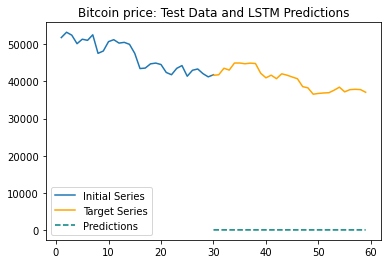

In [26]:
model = fit_LSTM(train_X, train_y, cell_units=30,  epochs=50) 

predict_and_plot(test_X_init, test_y, model, 
                 'Bitcoin price: Test Data and LSTM Predictions')

# LSTM model II

In [106]:
def fit_LSTM(train_X, train_y, cell_units, cell_units_l2,cell_units_l3, cell_units_l4, cell_units_l5, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1),return_sequences= True))
    model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1), return_sequences= True))
    model.add(LSTM(cell_units_l3, input_shape=(train_X.shape[1],1), return_sequences= True))
    model.add(LSTM(cell_units_l4, input_shape=(train_X.shape[1],1), return_sequences= True))
    model.add(LSTM(cell_units_l5, input_shape=(train_X.shape[1],1)))

    
    # add an output layer to make final predictions
    # we change the activation function here
    model.add(Dense(1, activation='softmax'))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=20, verbose=1)
    
    
    return model

In [107]:
series_days = 1400 
input_days = 60
test_days = 120

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df, series_days, 
                         input_days, test_days))


In [108]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (568, 60, 1)
Training output shape: (568,)
Test input shape: (60,)
Test output shape: (60,)


Epoch 1/30
29/29 [==============================] - 7s 64ms/step - loss: 731445120.0000
Epoch 2/30
29/29 [==============================] - 2s 63ms/step - loss: 731444864.0000
Epoch 3/30
29/29 [==============================] - 2s 63ms/step - loss: 731444800.0000
Epoch 4/30
29/29 [==============================] - 2s 63ms/step - loss: 731444928.0000
Epoch 5/30
29/29 [==============================] - 2s 61ms/step - loss: 731444736.0000
Epoch 6/30
29/29 [==============================] - 2s 61ms/step - loss: 731444864.0000
Epoch 7/30
29/29 [==============================] - 2s 62ms/step - loss: 731444864.0000
Epoch 8/30
29/29 [==============================] - 2s 65ms/step - loss: 731444800.0000
Epoch 9/30
29/29 [==============================] - 2s 66ms/step - loss: 731444992.0000
Epoch 10/30
29/29 [==============================] - 2s 64ms/step - loss: 731444992.0000
Epoch 11/30
29/29 [==============================] - 2s 64ms/step - loss: 731444992.0000
Epoch 12/30
29/29 [===========

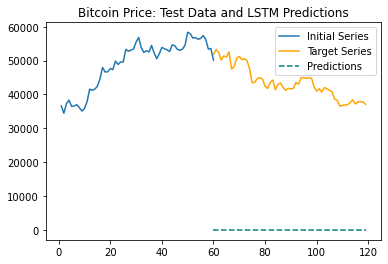

In [109]:

model = fit_LSTM(train_X, train_y, cell_units=55,cell_units_l2=45, cell_units_l3=35,cell_units_l4=25, cell_units_l5=15, epochs=30) 

predict_and_plot(test_X_init, test_y, model, 
                 'Bitcoin Price: Test Data and LSTM Predictions')

# LSTM Model III

In [112]:
# building the RNN

# Initialising the RNN
model = Sequential()

# construct a LSTM layer with specified number of hidden units
# per cell and desired sequence input format 
model.add(LSTM(55, input_shape=(train_X.shape[1],1),return_sequences= True))
model.add(LSTM(45, input_shape=(train_X.shape[1],1), return_sequences= True))
model.add(LSTM(35, input_shape=(train_X.shape[1],1), return_sequences= True))
model.add(LSTM(25, input_shape=(train_X.shape[1],1), return_sequences= True))
model.add(LSTM(15, input_shape=(train_X.shape[1],1), return_sequences= True))

model.add(LSTM(10, input_shape=(train_X.shape[1],1)))

    
# add an output layer to make final predictions
# we change the activation function here
model.add(Dense(1, activation='softmax'))
    
# define the loss function / optimization strategy, and fit
# the model with the desired number of passes over the data (epochs) 
model.compile( optimizer='adam', loss='mse', metrics=['accuracy'])

model.fit(train_X, train_y, epochs=50, batch_size=30, verbose=1)


Epoch 1/50
19/19 [==============================] - 8s 76ms/step - loss: 731444864.0000 - accuracy: 0.0000e+00
Epoch 2/50
19/19 [==============================] - 1s 72ms/step - loss: 731444992.0000 - accuracy: 0.0000e+00
Epoch 3/50
19/19 [==============================] - 1s 74ms/step - loss: 731444736.0000 - accuracy: 0.0000e+00
Epoch 4/50
19/19 [==============================] - 1s 78ms/step - loss: 731444928.0000 - accuracy: 0.0000e+00
Epoch 5/50
19/19 [==============================] - 1s 77ms/step - loss: 731444864.0000 - accuracy: 0.0000e+00
Epoch 6/50
19/19 [==============================] - 1s 75ms/step - loss: 731444928.0000 - accuracy: 0.0000e+00
Epoch 7/50
19/19 [==============================] - 1s 74ms/step - loss: 731444864.0000 - accuracy: 0.0000e+00
Epoch 8/50
19/19 [==============================] - 1s 75ms/step - loss: 731444864.0000 - accuracy: 0.0000e+00
Epoch 9/50
19/19 [==============================] - 1s 76ms/step - loss: 731444864.0000 - accuracy: 0.0000e+00
E

In [102]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 60, 55)            12540     
_________________________________________________________________
lstm_56 (LSTM)               (None, 60, 45)            18180     
_________________________________________________________________
lstm_57 (LSTM)               (None, 60, 35)            11340     
_________________________________________________________________
lstm_58 (LSTM)               (None, 60, 25)            6100      
_________________________________________________________________
lstm_59 (LSTM)               (None, 60, 15)            2460      
_________________________________________________________________
lstm_60 (LSTM)               (None, 15)                1860      
_________________________________________________________________
dense_14 (Dense)             (None, 1)               

In [113]:
# including early stopping
#early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=25)
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=25)

In [114]:
# Fitting the RNN to the Training set
res = model.fit(train_X, train_y
                    , batch_size=32
                    , epochs=100
                    #, validation_data=(X_val,y_val)
                    , validation_split=0.1
                    , callbacks=[early_stop]
                    , verbose = 0
                   ) 

In [116]:
list(res.history)

['loss', 'accuracy', 'val_loss', 'val_accuracy']

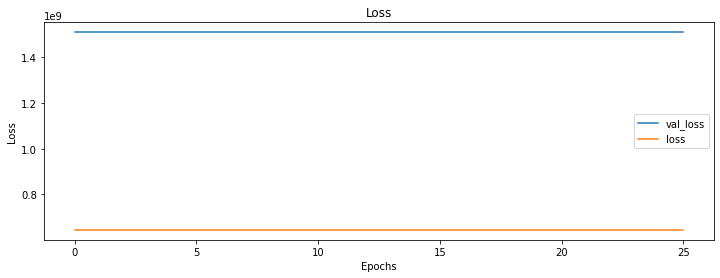

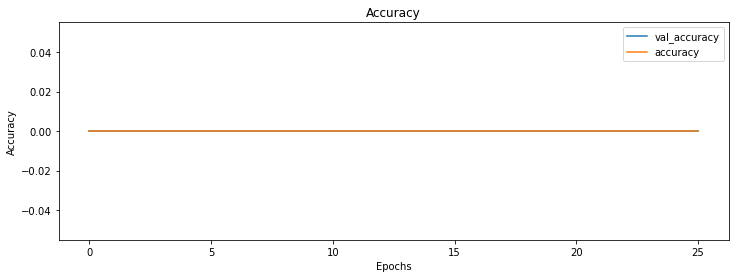

In [117]:
# Plotting Accuracy and Loss

results = res

history = results.history
plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(history['val_accuracy'])
plt.plot(history['accuracy'])
plt.legend(['val_accuracy', 'accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Sonuclar
1. Ilk modele gore layer sayisini 6 cikardim. 
2. activation function softmax yaptim
3. epoch sayisini 100 kadar cikardim
4. CV de ekledim.
5. Ayrica C. Best buying time in the past kismindan sonuc alamiyorum. Dakikalarca arka planda calisiyor ancak birsey uretmiyor. 

Ancak sonuc alamadim. 